In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from itertools import combinations
from sklearn.preprocessing import LabelEncoder

In [32]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler

def preprocess_data(df, le=None, scaler=None, has_target=True):
    # Drop first junk column if needed
    if df.columns[0] in [0, '0', 'NaN', None] or df.iloc[0,0] == 'NaN':
        df = df.drop(columns=df.columns[0])

    # Reset headers if first row contains names
    if 'age' in df.iloc[0].values:
        df.columns = df.iloc[0]
        df = df.drop(index=0).reset_index(drop=True)

    # Replace '?' with NaN and drop missing rows
    df = df.replace('?', np.nan).dropna().reset_index(drop=True)

    # Numeric and categorical columns
    numeric_cols = ['age', 'fnlwgt', 'education-num', 
                    'capital-gain', 'capital-loss', 'hours-per-week']
    categorical_cols = [col for col in df.columns if col not in numeric_cols + (['income'] if has_target else [])]

    # Convert numerics
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Encode target if present
    if has_target:
        le = LabelEncoder() if le is None else le
        df['income'] = le.fit_transform(df['income'])
        y = df[['income']]
    else:
        y = None

    # Features
    X = df.drop(columns=['income']) if has_target else df.copy()

    # One-hot encode categorical features
    X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

    # Standardize numeric features
    scaler = StandardScaler() if scaler is None else scaler
    if has_target:
        X[numeric_cols] = scaler.fit_transform(X[numeric_cols])
    else:
        X[numeric_cols] = scaler.transform(X[numeric_cols])

    return (X, y, le, scaler) if has_target else (X, scaler)



In [8]:
def plot_confusion_matrix(cm, y_true):
    """
    Plots the confusion matrix using a heatmap.

    Args:
        cm (np.ndarray): The confusion matrix.
        y_true (np.ndarray): The true labels for the test data.
    """
    # Create the plot using pure matplotlib
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Use imshow to create the heatmap
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the unique class names
           xticklabels=np.unique(y_true), yticklabels=np.unique(y_true),
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from itertools import combinations
import pandas as pd
from sklearn.preprocessing import LabelEncoder

def plot_svm_decision_boundaries_multi_feature(X, y, kernels, title_prefix="", C=1.0, gamma='scale'):
    """
    Plots the decision boundaries for multiple SVM models and multiple feature pairs,
    automatically handling non-numerical target labels and different data types for y.

    Args:
        X (pd.DataFrame): The input features (must have at least 2 columns).
        y (pd.Series or np.ndarray or pd.DataFrame): The target labels.
        kernels (list): A list of kernel strings (e.g., 'linear', 'rbf', 'poly').
        title_prefix (str): A prefix for the plot titles.
        C (float): The regularization parameter.
        gamma (str or float): Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.
    """
    # Standardize the y input to a pandas Series
    if isinstance(y, pd.DataFrame):
        if y.shape[1] != 1:
            raise ValueError("If 'y' is a DataFrame, it must contain a single column.")
        y_series = y.iloc[:, 0]
    elif isinstance(y, (pd.Series, np.ndarray)):
        # Convert to Series for consistent handling, and ravel to ensure 1D
        y_series = pd.Series(y).ravel()
    else:
        raise TypeError("y must be a pandas DataFrame, Series, or a NumPy array.")

    # Check the dtype of the uniform y_series and encode if necessary
    if y_series.dtype == 'object':
        print("Encoding string labels to numerical format...")
        le = LabelEncoder()
        y_encoded = le.fit_transform(y_series)
    else:
        y_encoded = y_series.values

    n_features = X.shape[1]
    if n_features < 2:
        raise ValueError("This function requires at least 2 features for plotting combinations.")

    feature_pairs = list(combinations(range(n_features), 2))
    n_pairs = len(feature_pairs)
    n_kernels = len(kernels)

    fig, axes = plt.subplots(n_kernels, n_pairs, figsize=(n_pairs * 6, n_kernels * 5),
                             constrained_layout=True)

    # Ensure axes is a 2D array even for a single row/column
    if n_kernels == 1 and n_pairs == 1:
        axes = np.array([[axes]])
    elif n_kernels == 1:
        axes = np.array([axes])
    elif n_pairs == 1:
        axes = axes.reshape(-1, 1)

    for i, kernel in enumerate(kernels):
        for j, (f1_idx, f2_idx) in enumerate(feature_pairs):
            ax = axes[i, j]

            # Select the two features for the current plot
            X_pair = X.iloc[:, [f1_idx, f2_idx]]
            f1_name = X.columns[f1_idx]
            f2_name = X.columns[f2_idx]

            # Train the SVM model on the selected features
            if kernel == 'poly':
                model = SVC(kernel=kernel, C=C, gamma=gamma, degree=3)
            else:
                model = SVC(kernel=kernel, C=C, gamma=gamma)
            
            # FIT THE MODEL WITH .values TO AVOID THE WARNING
            model.fit(X_pair.values, y_encoded)

            # Plot the data points with encoded labels
            ax.scatter(X_pair.iloc[:, 0], X_pair.iloc[:, 1], c=y_encoded, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

            # Create and plot the decision boundary
            xlim = ax.get_xlim()
            ylim = ax.get_ylim()
            xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 500),
                                 np.linspace(ylim[0], ylim[1], 500))
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)

            ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
            
            # Highlight the support vectors
            ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100,
                       linewidth=1, facecolors='none', edgecolors='k')
            
            # Set titles and labels
            ax.set_title(f"{title_prefix} {kernel.capitalize()} ({f1_name} vs {f2_name})")
            ax.set_xlabel(f1_name)
            ax.set_ylabel(f2_name)
            ax.set_aspect('equal', adjustable='box')

    plt.show()

In [10]:
def plot_best_svm_decision_boundary(grid_search, X, y):
    """
    Plots the decision boundaries for the best SVM model found by GridSearchCV.

    Args:
        grid_search (GridSearchCV): The fitted GridSearchCV object.
        X (pd.DataFrame): The input features (must be a DataFrame for feature names).
        y (pd.Series or np.ndarray): The target labels.
    """
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_kernel = best_params.get('kernel', 'linear') # Default to linear if not found

    # Standardize the y input and encode if necessary
    if isinstance(y, pd.DataFrame):
        if y.shape[1] != 1:
            raise ValueError("If 'y' is a DataFrame, it must contain a single column.")
        y_series = y.iloc[:, 0]
    elif isinstance(y, (pd.Series, np.ndarray)):
        y_series = pd.Series(y).ravel()
    else:
        raise TypeError("y must be a pandas DataFrame, Series, or a NumPy array.")
    
    if y_series.dtype == 'object':
        print("Encoding string labels to numerical format...")
        le = LabelEncoder()
        y_encoded = le.fit_transform(y_series)
    else:
        y_encoded = y_series.values

    n_features = X.shape[1]
    if n_features < 2:
        raise ValueError("This function requires at least 2 features for plotting combinations.")

    feature_pairs = list(combinations(range(n_features), 2))
    n_pairs = len(feature_pairs)
    
    fig, axes = plt.subplots(1, n_pairs, figsize=(n_pairs * 6, 6), constrained_layout=True)

    # Ensure axes is an array even for a single subplot
    if n_pairs == 1:
        axes = [axes]

    for j, (f1_idx, f2_idx) in enumerate(feature_pairs):
        ax = axes[j]
        
        # Select the two features for the current plot
        X_pair = X.iloc[:, [f1_idx, f2_idx]]
        f1_name = X.columns[f1_idx]
        f2_name = X.columns[f2_idx]

        # Use the best model from GridSearchCV
        model = best_model
        
        # Since the best model was trained on the full dataset, we'll retrain
        # a new instance of it on just the two features for plotting purposes.
        # This is the most reliable way to ensure the decision boundary is correct.
        plot_model = SVC(
            kernel=best_params.get('kernel'),
            C=best_params.get('C'),
            gamma=best_params.get('gamma')
        )
        if best_kernel == 'poly':
            plot_model.degree = best_params.get('degree', 3) # Handle poly degree separately
        plot_model.fit(X_pair.values, y_encoded)
        
        # Plot the data points
        ax.scatter(X_pair.iloc[:, 0], X_pair.iloc[:, 1], c=y_encoded, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

        # Create and plot the decision boundary
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 500),
                             np.linspace(ylim[0], ylim[1], 500))
        Z = plot_model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
        
        # Highlight the support vectors
        ax.scatter(plot_model.support_vectors_[:, 0], plot_model.support_vectors_[:, 1], s=100,
                   linewidth=1, facecolors='none', edgecolors='k')
        
        # Set titles and labels
        ax.set_title(f"Best Model ({best_kernel.capitalize()} kernel)\n({f1_name} vs {f2_name})")
        ax.set_xlabel(f1_name)
        ax.set_ylabel(f2_name)
        ax.set_aspect('equal', adjustable='box')

    plt.suptitle(f"GridSearchCV Best Model Decision Boundaries\nBest Params: {best_params}", y=1.05)
    plt.show()

In [3]:
# ### Reading-in the Iris data

file_path = '/Users/kennedygracemaloney/Downloads/project_adult.csv'

try:
    df = pd.read_csv(file_path, header=None, encoding='utf-8')
    print(f"Successfully loaded '{file_path}'. First 5 rows:")
    print(df.head())
    print(f"\n********************* \nDataset Shape: {df.shape} \n********************* \nDataset Columns: \n{df.columns}\n********************* \nData Description: \n{df.describe()} \n********************* \nDoes Data Contain Null Values \n{df.isnull().all()}")
    print(f"\n********************* \n Counts of Response Variables: \n {df.iloc[:,4].value_counts()}")
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
except pd.errors.EmptyDataError:
    print(f"Error: The file '{file_path}' is empty or contains no data.")
except pd.errors.ParserError as e:
    print(f"Error: A parsing error occurred while reading '{file_path}': {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Successfully loaded '/Users/kennedygracemaloney/Downloads/project_adult.csv'. First 5 rows:
        0    1                 2       3          4              5   \
0      NaN  age         workclass  fnlwgt  education  education-num   
1   5514.0   33         Local-gov  198183  Bachelors             13   
2  19777.0   36           Private   86459  Assoc-voc             11   
3  10781.0   58  Self-emp-not-inc  203039        9th              5   
4  32240.0   21           Private  180190  Assoc-voc             11   

                   6                7              8      9       10  \
0      marital-status       occupation   relationship   race     sex   
1       Never-married   Prof-specialty  Not-in-family  White  Female   
2  Married-civ-spouse  Exec-managerial        Husband  White    Male   
3           Separated     Craft-repair  Not-in-family  White    Male   
4  Married-civ-spouse  Farming-fishing        Husband  White    Male   

             11            12              13   

In [4]:
# preprocess data with created function
X, y, le, scaler = preprocess_data(df)


First 5 Rows of Data before transformation: 
        0    1                 2       3          4              5   \
0      NaN  age         workclass  fnlwgt  education  education-num   
1   5514.0   33         Local-gov  198183  Bachelors             13   
2  19777.0   36           Private   86459  Assoc-voc             11   
3  10781.0   58  Self-emp-not-inc  203039        9th              5   
4  32240.0   21           Private  180190  Assoc-voc             11   

                   6                7              8      9       10  \
0      marital-status       occupation   relationship   race     sex   
1       Never-married   Prof-specialty  Not-in-family  White  Female   
2  Married-civ-spouse  Exec-managerial        Husband  White    Male   
3           Separated     Craft-repair  Not-in-family  White    Male   
4  Married-civ-spouse  Farming-fishing        Husband  White    Male   

             11            12              13              14      15  
0  capital-gain  capita

In [11]:
# split data into training and test datasets
# can specify same proportion of classes in both sets with stratify=y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [12]:
# Train with linear kernel
model_linear = SVC(kernel='linear', C=1)
model_linear.fit(X_train, y_train.values.ravel())

SVC(C=1, kernel='linear')

In [13]:
# Make predictions on the scaled test set.
y_pred = model_linear.predict(X_test)


--- Confusion Matrix ---
[[4238  300]
 [ 624  878]]

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      4538
           1       0.75      0.58      0.66      1502

    accuracy                           0.85      6040
   macro avg       0.81      0.76      0.78      6040
weighted avg       0.84      0.85      0.84      6040



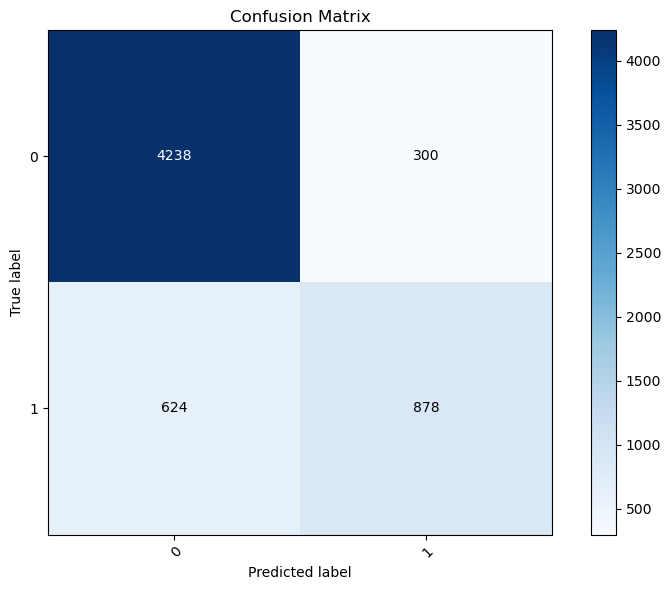

In [14]:
# Generate and display the confusion matrix and classification report
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

# Plot the predictions and the confusion matrix
plot_confusion_matrix(cm, y_test)

In [16]:
# Plot decision boundaries for different kernels
plot_svm_decision_boundaries_multi_feature(X_train, y_train, kernels=['linear'])

KeyboardInterrupt: 

<Figure size 2.736e+06x500 with 0 Axes>

In [ ]:
plot_svm_decision_boundaries_multi_feature(X_train, y_train, kernels=['rbf'])

In [ ]:
plot_svm_decision_boundaries_multi_feature(X_train, y_train, kernels=['poly'])

In [17]:
# We use GridSearchCV to find the best hyperparameters for the model.
# Cross-validation (CV) helps to get a more robust estimate of model performance
# and prevents overfitting to a single train-test split.

# Define the parameter grid to search over.
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}


# Initialize GridSearchCV with a 5-fold cross-validation strategy.
grid_search = GridSearchCV(
    estimator=SVC(),
    param_grid=param_grid,
    cv=5,                     # 5-fold cross-validation
    scoring='accuracy',       # Metric to optimize for
    n_jobs=-1,                # Use all available CPU cores
    verbose=1                 # Print progress
)

print("Starting hyperparameter search. This may take a moment...")
grid_search.fit(X_train, y_train.values.ravel())

Starting hyperparameter search. This may take a moment...
Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'poly']},
             scoring='accuracy', verbose=1)


--- Best Model Found by GridSearchCV ---
Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation accuracy: 0.8494

 Final evaluation of the best model on the test set...
Final accuracy on test set: 0.8493

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.94      0.90      4538
           1       0.76      0.58      0.66      1502

    accuracy                           0.85      6040
   macro avg       0.81      0.76      0.78      6040
weighted avg       0.84      0.85      0.84      6040


Confusion Matrix:
[[4257  281]
 [ 629  873]]


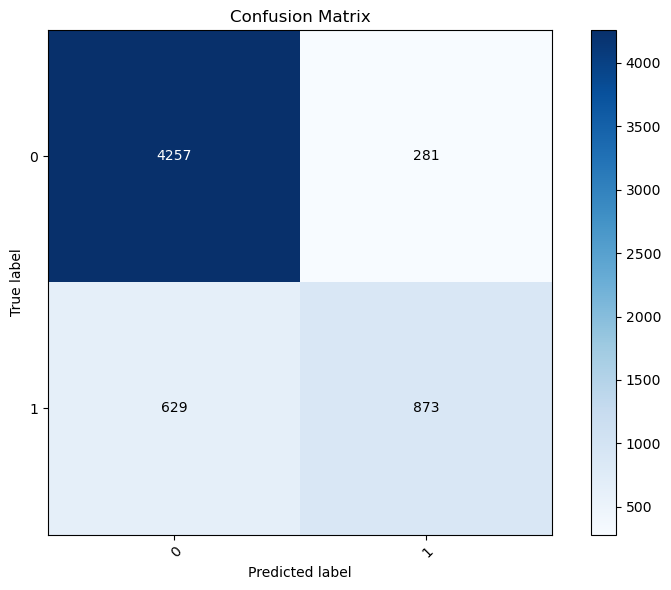

In [18]:
# Get the best estimator from the search.
best_model = grid_search.best_estimator_

print("\n--- Best Model Found by GridSearchCV ---")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

print("\n Final evaluation of the best model on the test set...")
# Predict using the best model found during the search.
final_y_pred = best_model.predict(X_test)
final_accuracy = accuracy_score(y_test, final_y_pred)

print(f"Final accuracy on test set: {final_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, final_y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, final_y_pred)
print(cm)

# Plot the predictions and the confusion matrix
plot_confusion_matrix(cm, y_test)

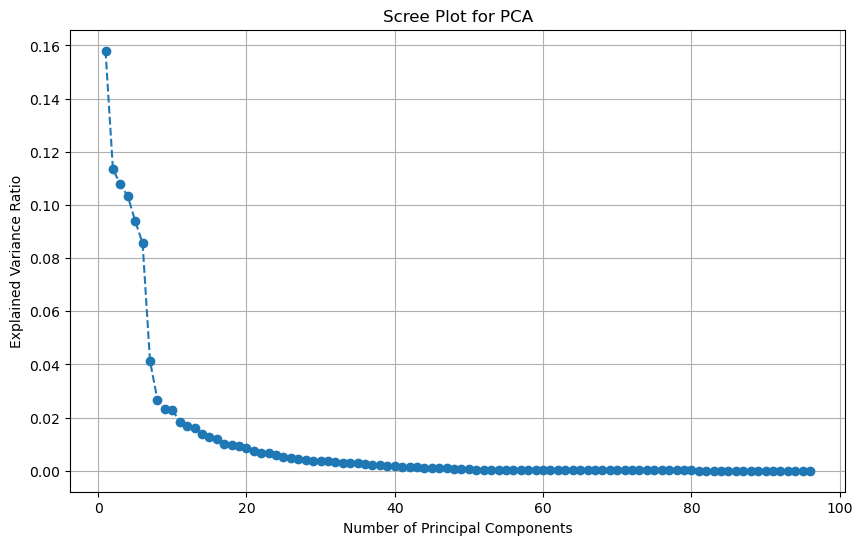

In [20]:
# Perform PCA without assuming a fixed number of components
# By default, PCA will compute all n_features components.
pca = PCA()
pca.fit(X_train) # this is on x train to compare performance 

plt.figure(figsize=(10, 6))
explained_variance_ratio = pca.explained_variance_ratio_
components = range(1, len(explained_variance_ratio) + 1)
plt.plot(components, explained_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot for PCA')
plt.grid(True)
plt.show()

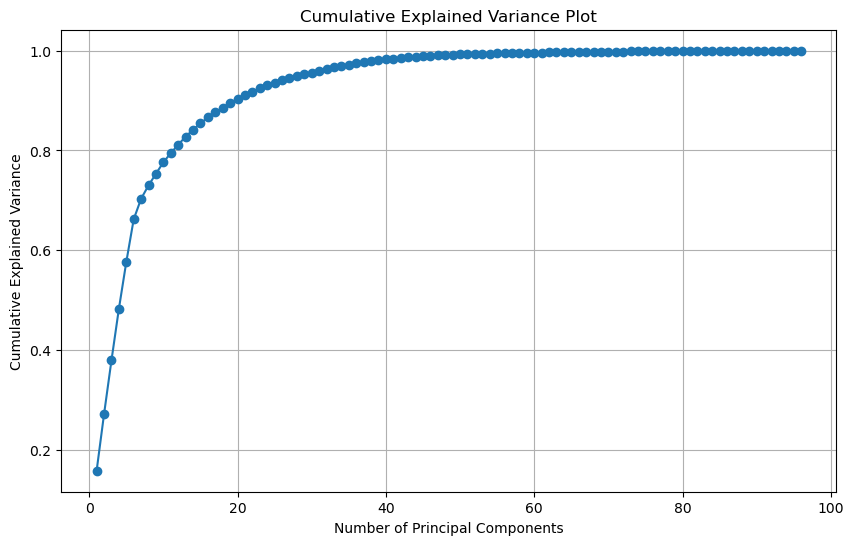

In [21]:
# reate the Cumulative Explained Variance Plot
plt.figure(figsize=(10, 6))
cumulative_variance = np.cumsum(explained_variance_ratio)
plt.plot(components, cumulative_variance, marker='o', linestyle='-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance Plot')
plt.grid(True)

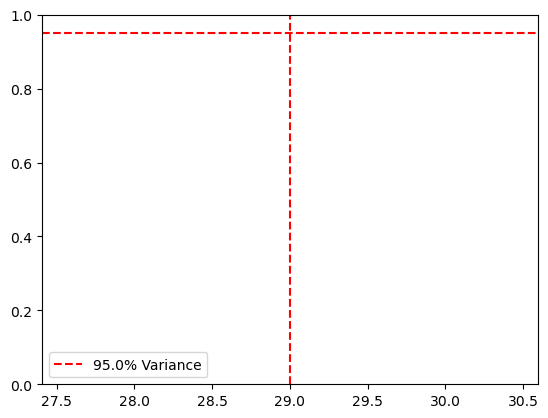

In [22]:
# Highlight a target variance, e.g., 95%
target_variance = 0.95
num_components_95 = np.argmax(cumulative_variance >= target_variance) + 1
plt.axvline(x=num_components_95, color='r', linestyle='--', label=f'{target_variance*100}% Variance')
plt.axhline(y=target_variance, color='r', linestyle='--')
plt.legend()
plt.show()

In [23]:
# Find the number of components for a target variance programmatically
num_components_for_95_percent = np.argmax(pca.explained_variance_ratio_.cumsum() >= 0.95) + 1
print(f"Number of components to explain 95% of variance: {num_components_for_95_percent}")

Number of components to explain 95% of variance: 29


In [33]:
# use number of components created in PCA to plot
# Create a DataFrame for the principal components for easier plotting
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train) # Fit and transform training data
X_test_pca = pca.transform(X_test) # Transform the test data using the fitted PCA

pca_df = pd.DataFrame(data=X_train_pca, columns=['principal component 1', 'principal component 2'])
pca_df['target'] = y_train.values.ravel()

Explained variance ratio of the components:
[0.15799863 0.11345123]
Total variance explained: 0.27


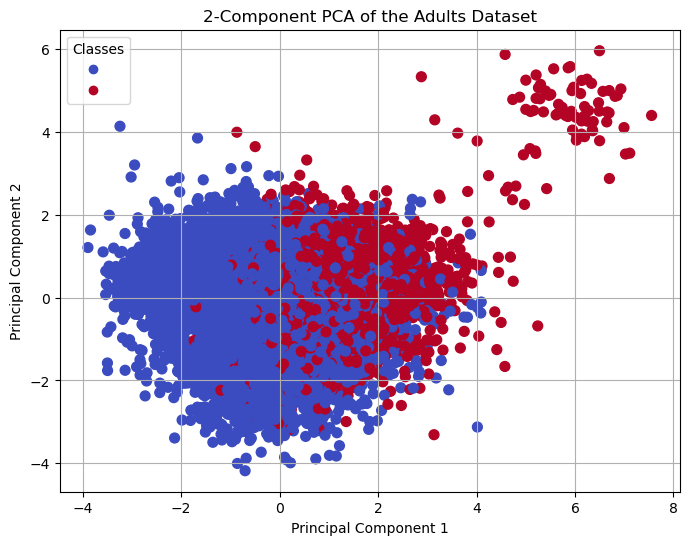

In [34]:
# Print the explained variance ratio
# This shows how much of the original data's variance is explained by each component.
print("Explained variance ratio of the components:")
print(pca.explained_variance_ratio_)
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.2f}")

# Visualize the results
# Plot the first two principal components, colored by the target class.
plt.figure(figsize=(8, 6))
scatter = plt.scatter(pca_df['principal component 1'], pca_df['principal component 2'],
                      c=pca_df['target'], cmap=plt.cm.coolwarm, s=50)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2-Component PCA of the Adults Dataset')
plt.legend(handles=scatter.legend_elements()[0], title="Classes")
plt.grid(True)
plt.show()

In [35]:
# Inspect the principal components_ attribute
# This shows the coefficients of the original features for each component
principal_components_matrix = pca.components_

# Create a DataFrame for better readability
component_df = pd.DataFrame(
    data=principal_components_matrix,
    columns=X.columns,
    index=['Principal Component 1', 'Principal Component 2']
)

print("Principal Component Loadings:")
print(component_df)

Principal Component Loadings:
                            age    fnlwgt  education-num  capital-gain  \
Principal Component 1  0.475855 -0.157354       0.466573      0.307076   
Principal Component 2 -0.579372  0.289617       0.614042      0.284096   

                       capital-loss  hours-per-week  workclass_Local-gov  \
Principal Component 1      0.226958        0.486458             0.020173   
Principal Component 2     -0.018168       -0.007868             0.004424   

                       workclass_Private  workclass_Self-emp-inc  \
Principal Component 1          -0.103183                0.030955   
Principal Component 2           0.019277               -0.003044   

                       workclass_Self-emp-not-inc  ...  \
Principal Component 1                    0.035214  ...   
Principal Component 2                   -0.029190  ...   

                       native-country_Portugal  native-country_Puerto-Rico  \
Principal Component 1                -0.000359              

In [36]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# Create and fit the GridSearchCV object with the PCA-transformed data
svc = SVC()
grid_search = GridSearchCV(svc, param_grid, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train_pca, y_train.values.ravel())

# Print the best parameters and score
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   3.4s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   4.3s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   4.5s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   4.5s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   4.5s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   7.6s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   8.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   8.1s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   8.3s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   8.7s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   5.9s
[CV] END ....................C=0.1, gamma=scale,


--- Best Model Found by GridSearchCV ---
Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation accuracy: 0.8126

 Final evaluation of the best model on the test set...
Final accuracy on test set: 0.8043

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.93      0.88      4538
           1       0.66      0.44      0.53      1502

    accuracy                           0.80      6040
   macro avg       0.75      0.68      0.70      6040
weighted avg       0.79      0.80      0.79      6040


Confusion Matrix:
[[4200  338]
 [ 844  658]]


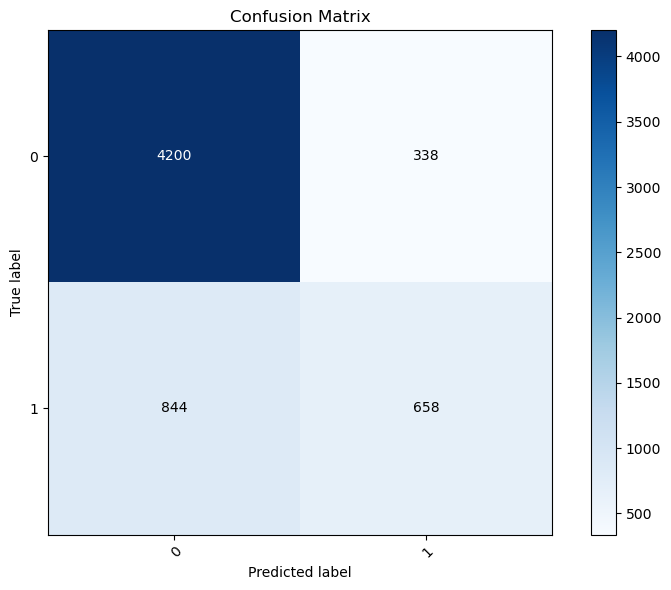

In [37]:
# Get the best estimator from the search.
best_model = grid_search.best_estimator_

print("\n--- Best Model Found by GridSearchCV ---")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

print("\n Final evaluation of the best model on the test set...")
# Predict using the best model found during the search.
final_y_pred = best_model.predict(X_test_pca)

final_accuracy = accuracy_score(y_test, final_y_pred)

print(f"Final accuracy on test set: {final_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, final_y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, final_y_pred)
print(cm)

# Plot the predictions and the confusion matrix
plot_confusion_matrix(cm, y_test)

In [63]:
!pip install joblib

In [70]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Load training data (replace with your training CSV)
train_path = '/Users/kennedygracemaloney/Downloads/project_adult.csv'
train_df = pd.read_csv(train_path)

X_train = train_df.drop(columns=['income'])
y_train = train_df['income']

# Encode categorical columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
X_train_encoded = pd.get_dummies(X_train, columns=categorical_cols)

# Standardize numeric columns
numeric_cols = X_train_encoded.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
X_train_encoded[numeric_cols] = scaler.fit_transform(X_train_encoded[numeric_cols])

# Create best SVM
best_model = SVC(C=1, gamma='scale', kernel='rbf')

# Train
best_model.fit(X_train_encoded, y_train)

# Load test data
test_path = '/Users/kennedygracemaloney/Downloads/project_validation_inputs.csv'
test_df = pd.read_csv(test_path)
X_test = test_df.drop(columns=['income'], errors='ignore')

# Encode categorical columns in test set
X_test_encoded = pd.get_dummies(X_test, columns=categorical_cols)

# Align test set with training set columns
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# Scale numeric columns
X_test_encoded[numeric_cols] = scaler.transform(X_test_encoded[numeric_cols])

# Predict
y_pred = best_model.predict(X_test_encoded)

# Save predictions
output_df = X_test.copy()
output_df['predictions'] = y_pred
output_df.to_csv('/Users/kennedygracemaloney/Downloads/project_svm_predictions.csv', index=False)
print("Predictions saved to CSV.")


Predictions saved to CSV.
